#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [4]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [5]:
def loss(X: np.ndarray, y: np.ndarray, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    import numpy as np  # Ensure NumPy is imported
    w = np.array(w)  # Convert w to a NumPy array
    z = X.dot(w) + w0  # Linear combination
    yz = y * z  # Element-wise multiplication
    logistic_loss = np.logaddexp(0, -yz).mean()  # Logistic loss computation
    l1_penalty = gamma * np.linalg.norm(w, 1)  # L1 regularization term
    l2_penalty = beta * np.linalg.norm(w, 2) ** 2  # L2 regularization term
    total_loss = logistic_loss + l1_penalty + l2_penalty  # Total loss
    return total_loss


#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [7]:
from typing import Tuple, List
import numpy as np

def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    '''
    Computes the gradients of the weights and intercept for logistic regression with L1 and L2 regularization.

    :param X: np.ndarray of shape (n_objects, n_features) -- feature matrix
    :param y: np.ndarray of shape (n_objects,) -- vector of correct labels
    :param w: List[float] of length (n_features,) -- the weights
    :param w0: float -- intercept
    :param gamma: float -- penalty hyperparameter for L1-regularization
    :param beta: float -- penalty hyperparameter for L2-regularization
    :return: Tuple containing the gradient with respect to w and w0
    '''
    w = np.array(w)  # Convert w to a NumPy array
    n_samples = X.shape[0]
    
    # Compute the linear combination of inputs and weights
    z = X.dot(w) + w0  # Shape: (n_samples,)
    
    # Compute y * z for use in logistic loss gradient
    yz = y * z  # Shape: (n_samples,)
    
    # Compute the probabilities using the logistic sigmoid function
    # We use exp(yz) because y * z might be negative
    exp_neg_yz = np.exp(-yz)
    p = 1 / (1 + exp_neg_yz)  # Shape: (n_samples,)
    
    # Compute the gradient of the logistic loss with respect to w
    grad_logistic_w = (-1 / n_samples) * X.T.dot(y * (1 - p))  # Shape: (n_features,)
    
    # Compute the gradient of the logistic loss with respect to w0
    grad_logistic_w0 = (-1 / n_samples) * np.sum(y * (1 - p))  # Scalar
    
    # Compute the gradient of the L1 regularization term
    grad_l1_w = gamma * np.sign(w)  # Shape: (n_features,)
    
    # Compute the gradient of the L2 regularization term
    grad_l2_w = 2 * beta * w  # Shape: (n_features,)
    
    # Sum all gradients for w
    grad_w = grad_logistic_w + grad_l1_w + grad_l2_w  # Shape: (n_features,)
    
    # The total gradient for w0 is just the logistic loss gradient
    grad_w0 = grad_logistic_w0  # Scalar
    
    return grad_w.tolist(), grad_w0


In [8]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [9]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        '''
        Initializes the logistic regression model with L1 and L2 regularization.

        :param beta: float -- penalty hyperparameter for L2-regularization
        :param gamma: float -- penalty hyperparameter for L1-regularization
        :param lr: float -- learning rate for the SGD optimizer
        :param tolerance: float -- minimal allowed movement in each iteration
        :param max_iter: int -- maximum number of iterations for the optimizer
        :param random_state: int -- seed for random number generator
        '''
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None  # Weights will be initialized during fitting
        self.w0 = None  # Intercept term

    def fit(self, X, y):
        '''
        Fits the logistic regression model to the data using SGD.

        :param X: np.ndarray of shape (n_samples, n_features) -- feature matrix
        :param y: np.ndarray of shape (n_samples,) -- target labels (-1 or 1)
        :return: self
        '''
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        # Initialize weights and intercept
        self.w = np.random.randn(n_features)
        self.w0 = 0.0

        for iteration in range(self.max_iter):
            # Compute gradients
            grad_w, grad_w0 = get_grad(X, y, self.w.tolist(), self.w0, self.gamma, self.beta)
            grad_w = np.array(grad_w)

            # Save old weights for convergence check
            w_old = self.w.copy()

            # Update weights and intercept
            self.w -= self.lr * grad_w
            self.w0 -= self.lr * grad_w0

            # Check for convergence
            weight_change = np.linalg.norm(self.w - w_old)
            if weight_change < self.tolerance:
                print(f'Converged after {iteration + 1} iterations')
                break

        return self

    def predict(self, X):
        '''
        Predicts class labels for samples in X.

        :param X: np.ndarray of shape (n_samples, n_features) -- feature matrix
        :return: np.ndarray of shape (n_samples,) -- predicted class labels (-1 or 1)
        '''
        linear_output = X.dot(self.w) + self.w0
        predictions = np.where(linear_output >= 0, 1, -1)
        return predictions

    def predict_proba(self, X):
        '''
        Estimates class probabilities for samples in X.

        :param X: np.ndarray of shape (n_samples, n_features) -- feature matrix
        :return: np.ndarray of shape (n_samples, 2) -- probabilities for each class
        '''
        linear_output = X.dot(self.w) + self.w0
        proba_positive = 1 / (1 + np.exp(-linear_output))
        proba_negative = 1 - proba_positive
        return np.vstack((proba_negative, proba_positive)).T


In [11]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [14]:
from matplotlib.colors import ListedColormap  # Add this import

def plot_decision_boundary(model, X, y):
    '''
    Plots the decision boundary of a logistic regression model along with the data points.

    :param model: Trained logistic regression model (instance of Logit class)
    :param X: np.ndarray of shape (n_samples, 2) -- feature matrix
    :param y: np.ndarray of shape (n_samples,) -- target labels (-1 or 1)
    '''
    # Create a mesh grid for plotting
    h = 0.02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1  # for feature 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1  # for feature 2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict class labels for all points in the mesh grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    # Define custom color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    # Plot the decision boundary by assigning a color to each point in the mesh grid
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.6)

    # Plot also the training points
    plt.scatter(X[:, 0][y == -1], X[:, 1][y == -1], c='red', label='Class -1', edgecolor='k', s=50)
    plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1], c='blue', label='Class 1', edgecolor='k', s=50)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')
    plt.legend()
    plt.show()

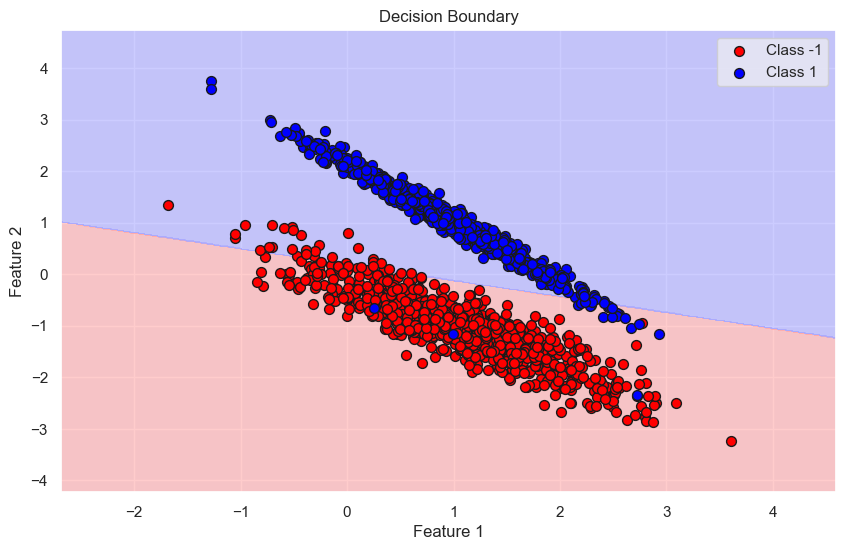

In [15]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [16]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

def loss(X, y, w, w0, gamma=1., beta=1.):
    w = np.array(w)  # Преобразуем w в массив NumPy
    z = X.dot(w) + w0  # Линейная комбинация
    yz = y * z  # Поэлементное умножение
    logistic_loss = np.logaddexp(0, -yz).mean()  # Вычисление логистической функции потерь
    l1_penalty = gamma * np.linalg.norm(w, 1)  # L1 регуляризация
    l2_penalty = beta * np.linalg.norm(w, 2) ** 2  # L2 регуляризация
    total_loss = logistic_loss + l1_penalty + l2_penalty  # Общая функция потерь
    return total_loss

def get_grad(X, y, w, w0, gamma=1., beta=1.):
    w = np.array(w)
    n_samples = X.shape[0]
    z = X.dot(w) + w0
    yz = y * z
    exp_neg_yz = np.exp(-yz)
    p = 1 / (1 + exp_neg_yz)
    grad_logistic_w = (-1 / n_samples) * X.T.dot(y * (1 - p))
    grad_logistic_w0 = (-1 / n_samples) * np.sum(y * (1 - p))
    grad_l1_w = gamma * np.sign(w)
    grad_l2_w = 2 * beta * w
    grad_w = grad_logistic_w + grad_l1_w + grad_l2_w
    grad_w0 = grad_logistic_w0
    return grad_w.tolist(), grad_w0

class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        '''
        beta: гиперпараметр регуляризации L2
        gamma: гиперпараметр регуляризации L1
        tolerance: минимальное изменение весов для остановки обучения
        lr: скорость обучения
        max_iter: максимальное количество итераций
        random_state: для воспроизводимости результатов
        '''
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None
        self.w0 = None
        self.loss_history = []  # Добавляем список для хранения истории функции потерь

    def fit(self, X, y):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        self.w = np.random.randn(n_features)
        self.w0 = 0.0

        for iteration in range(self.max_iter):
            # Вычисляем градиенты
            grad_w, grad_w0 = get_grad(X, y, self.w.tolist(), self.w0, self.gamma, self.beta)
            grad_w = np.array(grad_w)
            w_old = self.w.copy()

            # Обновляем веса
            self.w -= self.lr * grad_w
            self.w0 -= self.lr * grad_w0

            # Вычисляем и сохраняем значение функции потерь
            current_loss = loss(X, y, self.w, self.w0, self.gamma, self.beta)
            self.loss_history.append(current_loss)

            # Проверяем критерий сходимости
            weight_change = np.linalg.norm(self.w - w_old)
            if weight_change < self.tolerance:
                print(f'Сошлось после {iteration + 1} итераций')
                break

        return self

    def predict(self, X):
        linear_output = X.dot(self.w) + self.w0
        predictions = np.where(linear_output >= 0, 1, -1)
        return predictions

    def predict_proba(self, X):
        linear_output = X.dot(self.w) + self.w0
        proba_positive = 1 / (1 + np.exp(-linear_output))
        proba_negative = 1 - proba_positive
        return np.vstack((proba_negative, proba_positive)).T


In [17]:
import matplotlib.pyplot as plt

def plot_loss_history(model):
    '''
    Отображает график изменения значения функции потерь от номера итерации.

    :param model: обученная модель класса Logit, у которой есть атрибут loss_history
    '''
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(model.loss_history) + 1), model.loss_history, marker='o')
    plt.title('Зависимость функции потерь от номера итерации')
    plt.xlabel('Номер итерации')
    plt.ylabel('Значение функции потерь')
    plt.grid(True)
    plt.show()


#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

     Kernel      C  Accuracy  Precision    Recall  F1-Score   AUC-ROC
0    linear    0.1  0.866667   0.800000  0.923077  0.857143  0.924208
1    linear    1.0  0.866667   0.800000  0.923077  0.857143  0.924208
2    linear   10.0  0.866667   0.781250  0.961538  0.862069  0.924208
3    linear  100.0  0.866667   0.781250  0.961538  0.862069  0.924208
4      poly    0.1  0.733333   0.625000  0.961538  0.757576  0.930995
5      poly    1.0  0.733333   0.625000  0.961538  0.757576  0.930995
6      poly   10.0  0.800000   0.694444  0.961538  0.806452  0.934389
7      poly  100.0  0.800000   0.694444  0.961538  0.806452  0.935520
8       rbf    0.1  0.850000   0.774194  0.923077  0.842105  0.950226
9       rbf    1.0  0.850000   0.774194  0.923077  0.842105  0.953620
10      rbf   10.0  0.883333   0.827586  0.923077  0.872727  0.928733
11      rbf  100.0  0.883333   0.827586  0.923077  0.872727  0.918552
12  sigmoid    0.1  0.850000   0.774194  0.923077  0.842105  0.913462
13  sigmoid    1.0  

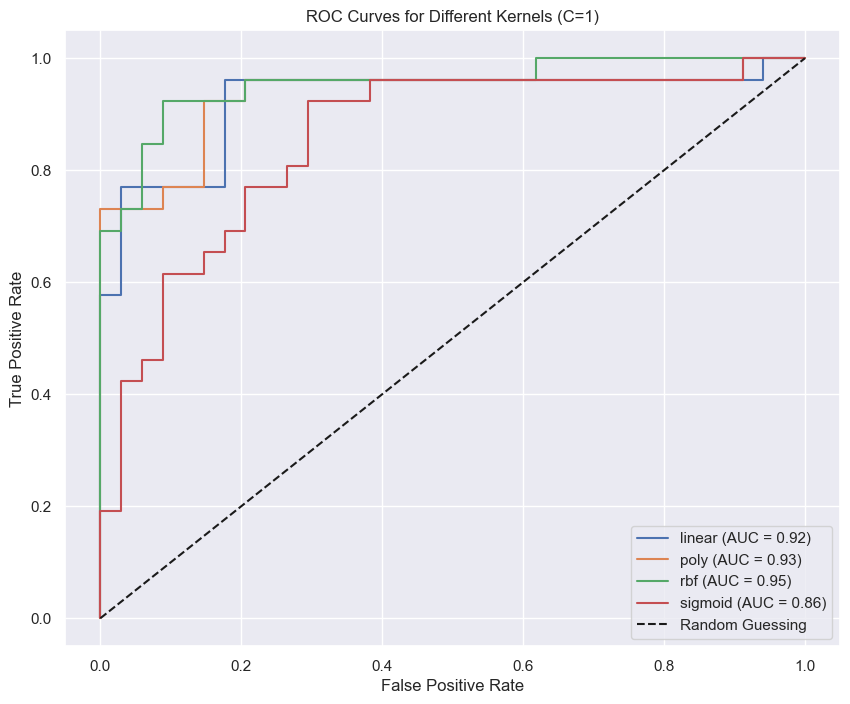

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split
# Generate synthetic dataset
X, y = make_classification(n_samples=200, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, random_state=42)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
C_values = [0.1, 1, 10, 100]
# Initialize a list to store results
results = []

for kernel in kernels:
    for C in C_values:
        # Initialize the model
        model = SVC(kernel=kernel, C=C, probability=True, random_state=42)
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict labels and probabilities
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)
        
        # Append the results
        results.append({
            'Kernel': kernel,
            'C': C,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1,
            'AUC-ROC': auc
        })
import pandas as pd

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)
plt.figure(figsize=(10, 8))

for kernel in kernels:
    # Initialize the model
    model = SVC(kernel=kernel, C=1, probability=True, random_state=42)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict probabilities
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{kernel} (AUC = {auc_score:.2f})')

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.title('ROC Curves for Different Kernels (C=1)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [19]:
import numpy as np

class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        '''
        :param n_neighbors: int -- number of nearest neighbors to use
        :param metric: str -- distance metric to use ('euclidean' or 'manhattan')
        '''
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train = None
        self.y_train = None
        self.classes_ = None
        self.class_to_index = None

    def fit(self, X, y):
        '''
        Stores the training data.

        :param X: np.ndarray of shape (n_samples, n_features) -- training feature matrix
        :param y: np.ndarray of shape (n_samples,) -- training labels
        :return: self
        '''
        self.X_train = X
        self.y_train = y
        self.classes_ = np.unique(y)
        # Map classes to indices for probability calculations
        self.class_to_index = {cls: idx for idx, cls in enumerate(self.classes_)}
        return self

    def _compute_distances(self, X):
        '''
        Computes distances between test points and training points.

        :param X: np.ndarray of shape (n_test_samples, n_features) -- test feature matrix
        :return: np.ndarray of shape (n_test_samples, n_train_samples) -- distances
        '''
        if self.metric == 'euclidean':
            distances = np.sqrt(np.sum((X[:, np.newaxis, :] - self.X_train[np.newaxis, :, :]) ** 2, axis=2))
        elif self.metric == 'manhattan':
            distances = np.sum(np.abs(X[:, np.newaxis, :] - self.X_train[np.newaxis, :, :]), axis=2)
        else:
            raise ValueError(f"Unsupported metric '{self.metric}'")
        return distances

    def predict(self, X):
        '''
        Predicts class labels for samples in X.

        :param X: np.ndarray of shape (n_samples, n_features) -- test feature matrix
        :return: np.ndarray of shape (n_samples,) -- predicted class labels
        '''
        distances = self._compute_distances(X)
        y_pred = []
        for dist in distances:
            # Indices of the k nearest neighbors
            idx = np.argsort(dist)[:self.n_neighbors]
            nearest_labels = self.y_train[idx]
            # Count occurrences of each class among the neighbors
            counts = np.zeros(len(self.classes_), dtype=int)
            for label in nearest_labels:
                index = self.class_to_index[label]
                counts[index] += 1
            # Choose the class with the highest count
            max_count = np.max(counts)
            max_indices = np.where(counts == max_count)[0]
            # Handle tie-breaker by selecting the class with the smallest index
            chosen_index = min(max_indices)
            y_pred.append(self.classes_[chosen_index])
        return np.array(y_pred)

    def predict_proba(self, X):
        '''
        Estimates class probabilities for samples in X.

        :param X: np.ndarray of shape (n_samples, n_features) -- test feature matrix
        :return: np.ndarray of shape (n_samples, n_classes) -- probabilities for each class
        '''
        distances = self._compute_distances(X)
        y_proba = []
        for dist in distances:
            idx = np.argsort(dist)[:self.n_neighbors]
            nearest_labels = self.y_train[idx]
            counts = np.zeros(len(self.classes_), dtype=int)
            for label in nearest_labels:
                index = self.class_to_index[label]
                counts[index] += 1
            total = counts.sum()
            probs = counts / total
            y_proba.append(probs)
        return np.array(y_proba)


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [22]:
import numpy as np
import gzip
import os
import urllib.request

def download_and_load_mnist(path, kind='train'):
    """Download and load Fashion-MNIST data."""
    base_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'

    files = {
        'train-images': 'train-images-idx3-ubyte.gz',
        'train-labels': 'train-labels-idx1-ubyte.gz',
        't10k-images': 't10k-images-idx3-ubyte.gz',
        't10k-labels': 't10k-labels-idx1-ubyte.gz'
    }

    # Ensure the directory exists
    os.makedirs(path, exist_ok=True)

    # Download files if they don't exist
    for file in files.values():
        if not os.path.exists(os.path.join(path, file)):
            print(f'Downloading {file}...')
            urllib.request.urlretrieve(base_url + file, os.path.join(path, file))

    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte.gz')

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(
            imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels

# Load the training and testing data
X_train_full, y_train_full = download_and_load_mnist('data/fashion', kind='train')
X_test_full, y_test_full = download_and_load_mnist('data/fashion', kind='t10k')

# Combine train and test sets
X_total = np.vstack((X_train_full, X_test_full))
y_total = np.hstack((y_train_full, y_test_full))

# Normalize the images
X_total = X_total / 255.0

# Split the data as per your requirement
X_train = X_total[:50000]
y_train = y_total[:50000]
X_test = X_total[50000:]
y_test = y_total[50000:]

# Verify the shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (50000, 784)
y_train shape: (50000,)
X_test shape: (20000, 784)
y_test shape: (20000,)


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

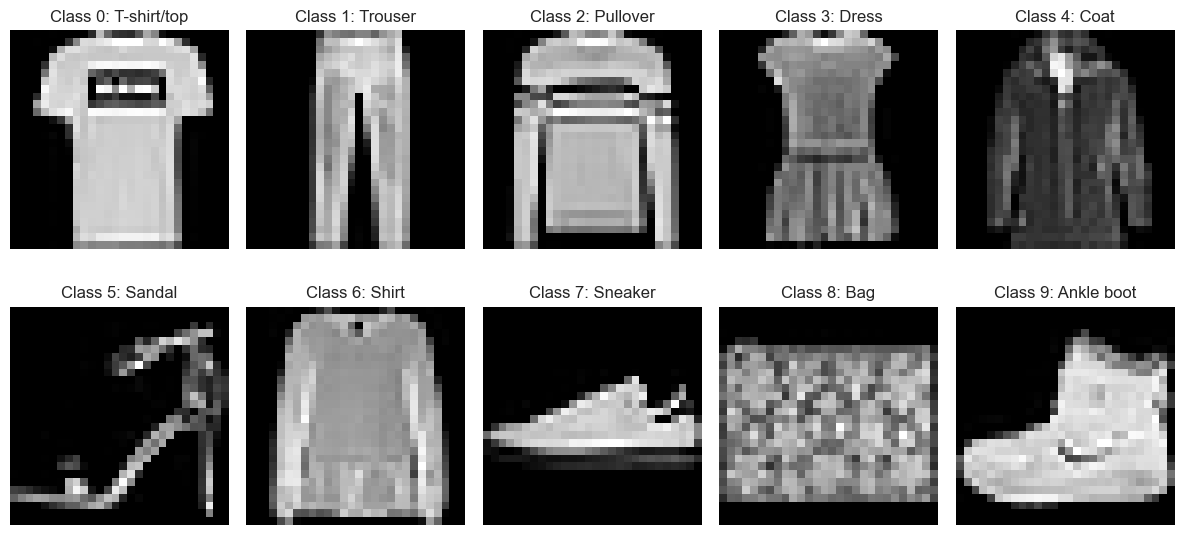

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import os
import urllib.request

# Function to download and load Fashion MNIST data
def download_and_load_mnist(path, kind='train'):
    base_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'

    files = {
        'train-images': 'train-images-idx3-ubyte.gz',
        'train-labels': 'train-labels-idx1-ubyte.gz',
        't10k-images': 't10k-images-idx3-ubyte.gz',
        't10k-labels': 't10k-labels-idx1-ubyte.gz'
    }

    os.makedirs(path, exist_ok=True)

    for file in files.values():
        if not os.path.exists(os.path.join(path, file)):
            print(f'Downloading {file}...')
            urllib.request.urlretrieve(base_url + file, os.path.join(path, file))

    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte.gz')

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(
            imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels

# Load the data
X_train_full, y_train_full = download_and_load_mnist('data/fashion', kind='train')
X_test_full, y_test_full = download_and_load_mnist('data/fashion', kind='t10k')

# Combine train and test sets
X_total = np.vstack((X_train_full, X_test_full))
y_total = np.hstack((y_train_full, y_test_full))

# Normalize pixel values
X_total = X_total / 255.0

# Split the data: first 50,000 for training, the rest for testing
X_train = X_total[:50000]
y_train = y_total[:50000]
X_test = X_total[50000:]
y_test = y_total[50000:]

# Mapping of class labels to names
class_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

# Visualization code (as provided above)
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i in range(10):
    index = np.where(y_train == i)[0][0]
    image = X_train[index].reshape(28, 28)
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Class {i}: {class_labels[i]}")
    axes[i].axis('off')

plt.tight_layout()


#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [26]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load the Fashion MNIST dataset
fashion_mnist = fetch_openml(name='Fashion-MNIST', version=1)

# Get the data and target
X_total = fashion_mnist.data
y_total = fashion_mnist.target.astype(np.int8)

# Split the data
X_train = X_total[:50000]
y_train = y_total[:50000]
X_test = X_total[50000:]
y_test = y_total[50000:]

# StandardScaler
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train)
X_test_standard = scaler_standard.transform(X_test)

# MinMaxScaler
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)

# Logistic Regression with StandardScaler
logreg = LogisticRegression(max_iter=1000, solver='saga', multi_class='multinomial', n_jobs=-1)
logreg.fit(X_train_standard, y_train)
y_pred_standard = logreg.predict(X_test_standard)
accuracy_standard = accuracy_score(y_test, y_pred_standard)
print(f"Logistic Regression Accuracy with StandardScaler: {accuracy_standard:.4f}")

# KNN with MinMaxScaler
knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train_minmax, y_train)
y_pred_minmax = knn.predict(X_test_minmax)
accuracy_minmax = accuracy_score(y_test, y_pred_minmax)
print(f"KNN Accuracy with MinMaxScaler: {accuracy_minmax:.4f}")


C:\Users\zahar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


KeyboardInterrupt: 

#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [27]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the Fashion MNIST dataset
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)

# Get the data and target
X_total = fashion_mnist.data
y_total = fashion_mnist.target.astype(np.int8)

# Split the data: first 50,000 samples for training, the remaining 20,000 for testing
X_train, X_test = X_total[:50000], X_total[50000:]
y_train, y_test = y_total[:50000], y_total[50000:]

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Hyperparameter tuning for KNeighborsClassifier
param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'p': [1, 2]
}

knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search_knn.fit(X_train, y_train)

# Hyperparameter tuning for LogisticRegression
param_grid_lr = {
    'C': [0.01, 0.1, 1.0],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['saga'],
    'multi_class': ['multinomial'],
    'l1_ratio': [0, 0.5, 1]
}

lr = LogisticRegression(max_iter=1000)
grid_search_lr = GridSearchCV(
    estimator=lr,
    param_grid=param_grid_lr,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search_lr.fit(X_train, y_train)

# Results for KNN
print("Best parameters for KNN:")
print(grid_search_knn.best_params_)
print(f"Best cross-validation accuracy: {grid_search_knn.best_score_:.4f}")

best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Test set accuracy for KNN: {accuracy_knn:.4f}")

# Results for Logistic Regression
print("\nBest parameters for Logistic Regression:")
print(grid_search_lr.best_params_)
print(f"Best cross-validation accuracy: {grid_search_lr.best_score_:.4f}")

best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Test set accuracy for Logistic Regression: {accuracy_lr:.4f}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits


KeyboardInterrupt: 

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

Когда я обучаю логистическую регрессию с помощью SGD на датасете, где у всех объектов два одинаковых признака, модель не может найти зависимость между признаками и метками классов. Поскольку все признаки идентичны для каждого объекта, линейная комбинация весов и признаков будет одинаковой для всех примеров. Это приводит к тому, что модель будет выдавать одну и ту же вероятность для каждого объекта. Поскольку классы распределены поровну (5000 отрицательных и 5000 положительных), оптимальной вероятностью, которую модель будет предсказывать, является 0,5. Таким образом, модель не сможет различать классы и будет фактически угадывать. Градиенты в процессе обучения будут близки к нулю, поэтому веса не будут обновляться, и модель не обучится. В результате точность модели на тестовых данных будет около 50%, что эквивалентно случайному угадыванию. Это демонстрирует, что без информативных и вариативных признаков модель не способна обучаться и делать осмысленные предсказания.

#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.